#### TF.SnoqualmieData.SupportingObs
Prepares Snoqualmie data to be used in evaluating a model:

- snow pit obs
- surface temperature (broken down by snow surface and ground surface temperature)
- snow height
- SWE (derived)
- melt outflow
- Observed fluxes: 4 stream rad, turb., ground

In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import subplots function for plotting:q
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Solargeometry
import solargeo

In [5]:
#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirData = '/Users/karllapo/Desktop/Documents/GroundObs/Snoqualmie/Raw/SNQ_Data/'     # Unprocessed Snoqualmie data
dirTArray = dirPre + 'GroundObs/Snoqualmie/Raw/TArray/'                # Unprocessed Snoq. temperature array
dirProj = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/'           # Project directory
dirPrint = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirOut = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'    # Processed data directory

## Read Supporting Data - Time Series

In [6]:
#### Supporting information - read QC'ed half-hour data
def parse(y, mo, dy, hr, mn):
    s = '00'
    date_str = y+':'+mo+':'+dy+'_'+hr+':'+mn+':'+s
    dt = datetime.strptime(date_str,"%Y:%m:%d_%H:%M:%S")
    return dt

os.chdir(dirData + 'Quality_Controled')
datafile = 'SNQ_QC_30min_2013_2015.csv'
support = pd.read_csv(datafile,sep=',',header=0,na_values=-9999,skiprows=[1,2],\
                   parse_dates={'Datetime' : [0,1,2,3,4]},date_parser=parse,index_col='Datetime')


### Read raw data to get wind direction

In [13]:
#### Supporting information - read QC'ed half-hour data
def parse(y, mo, dy, hr, mn):
    s = '00'
    date_str = y+':'+mo+':'+dy+'_'+hr+':'+mn+':'+s
    dt = datetime.strptime(date_str,"%Y:%m:%d_%H:%M:%S")
    return dt

os.chdir(dirData + 'Raw')
datafile = 'Tower_B_raw_10min_2013_2015.csv'
raw = pd.read_csv(datafile, sep=',', header=0, na_values='NAN', skiprows=[1,2],\
                  parse_dates={'Datetime' : [0,1,2,3,4]}, date_parser=parse, index_col='Datetime')


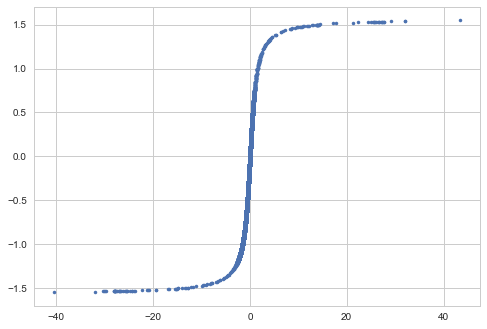

In [35]:
# For the time being I'm ignoring wind direction, because it looks all sorts of crazy town. Like the below plot. What.

plt.plot(raw.Ux_csat_Avg.values, raw.Uy_csat_Avg.values, '.')

# windDirection = np.arctan2(raw.Uy_csat_Avg.values, raw.Ux_csat_Avg.values) * 180 / np.pi + 180
# plt.plot(windDirection)
# windSpeed = np.sqrt(raw.Ux_csat_Avg ** 2 + raw.Uy_csat_Avg ** 2)
# import windrose
# ax = windrose.WindroseAxes.from_ax()
# ax.bar(windDirection, windSpeed, edgecolor='white')
# ax.set_legend()

In [4]:
## Reindex to a common time step with forcing data
os.chdir(dirOut)
ds = xr.open_dataset('SnoqualmieObs.ModelForcing.wy2013_wy2015.nc')
support = support.reindex(ds.time.values,fill_value=np.nan)

## Convert to xarray Dataset
support = xr.Dataset(support)
support = support.rename({'Datetime':'time'})

In [5]:
## Drop unnecessary fields
drop_variable_list = ['VWC','GT']
for dv in drop_variable_list:
    ds_varnames = support.data_vars.keys()
    drops = [s for s in ds_varnames if dv in s]
    support = support.drop(drops)

## Format Supporting Data
- split up Tsrf into a snow surface temperature and ground surface temperature time series (based on snowdepth)
- combing Tsrf1 and Tsrf2

In [6]:
# Average together both surface IR thermometers to get a single time series
support['Tsrf'] = xr.concat([support.Tsrf_1,support.Tsrf_2],'concatDim').mean(dim='concatDim')

Convert into a snow surface temperature and a ground surface temperature time series

In [7]:
# Take daily average, reindex to half-hourly time series, use in snow presence criteria
TsrfDaily = support.Tsrf.resample(how='mean',freq='d',dim='time',label='left')
TsrfDaily = TsrfDaily.reindex_like(support,method='ffill')

# bare ground when no snowdepth recorded or the daily surface temperature is above freezing
groundSurfTemp = support.Tsrf[(support.Snowdepth == 0) | (TsrfDaily > 0.5)]

# snow covered ground when snow is observed and the surface temperature is below freezing
snowSurfTemp = support.Tsrf[(support.Snowdepth > 0) & (TsrfDaily < 0.5)]

# Assign to support xarray.Dataset
support['groundTs'] = groundSurfTemp
support['snowTs'] = snowSurfTemp

Create snow presence variable

In [8]:
snowPres = ((support.Snowdepth > 0) | (TsrfDaily < 0.5))
support['SP'] = snowPres.astype(int)

## Temperature/RH/Wind Array 
5 minute data @ 6 heights

In [11]:
#### Supporting information - Temperature Array (Colin's Mary Gates project)
def parse(y, mo, dy, hr, mn):
    s = '00'
    date_str = y + ':' + mo + ':' + dy + '_' + hr + ':' + mn + ':' + s
    dt = datetime.strptime(date_str,"%Y:%m:%d_%H:%M:%S")
    return dt

os.chdir(dirTArray)
datafile = 'MG_Combined_Data.csv'
TArray = pd.read_csv(datafile, sep=',', header=0, na_values=-9999,
                     parse_dates=[3], index_col=3)

## Convert to xarray Dataset
TArray = xr.Dataset(TArray)
TArray = TArray.rename({'Time (GMT -07:00)': 'time'})

In [13]:
## Drop unnecessary fields
drop_variable_list = ['Year','Day','Hr:Min','Batt Volt']
for dv in drop_variable_list:
    ds_varnames = TArray.data_vars.keys()
    drops = [s for s in ds_varnames if dv in s]
    TArray = TArray.drop(drops)

In [14]:
## Save to netcdf
os.chdir(dirOut)
support.to_netcdf('SnoqualmieObs.SupportData.wy2013_wy2015.nc', mode='w')
TArray.to_netcdf('SnoqualmieObs.SupportData.TArray.Spring2015.nc',mode='w')